## Notebook description/goals

    -Learning the MOCSY toolbox for calc. carbonate chemistry. 
    -Development of pipeline for MOCSY-based calculation of air-sea co2 flux
    -examples https://github.com/jamesorr/mocsy/blob/master/notebooks/mocsy_examples.ipynb
    
### steps

    -import model output and make arrays from: temp, sal, alk, dic, sil (?) phos? 
    
    -figure out how to get wind (do i need to interpolate it?)
    
    -sanity check for MOCSY calculations
    
    -write down equation for air-sea flux of CO2 and perform sanity check. 
    
    -eventually: put this into an automatic script that:
        -retrieves model output
        -retreives wind
        -calculates air-sea flux of co2 and o2 and puts them into a netcdf (probably along with wind speed)

In [120]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [121]:
import sys
sys.path.append('/data/tjarniko/MEOPAR/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ')
import mocsy
import VIZ_plots as VP

import time
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
import seawater as sw
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import reload
plt.style.use('seaborn')
import netCDF4 as nc
import numpy as np
import cmocean as cm

""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline

In [122]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ/VIZ_plots.py'>

## load dataset and reshape (why does fortran only take 1D arrays?)

In [131]:
w = nc.Dataset('/data/tjarniko/results/may10_a8/SKOG_1d_20160415_20160429_ptrc_T.nc')
wp = nc.Dataset('/data/tjarniko/results/may10_a8/SKOG_1d_20160415_20160429_grid_T.nc')


tDIC = w.variables['dissolved_inorganic_carbon'][0,0,:,:] * 10.e-6
tTA = w.variables['total_alkalinity'][0,0,:,:] * 10.e-6
tTEMP = wp.variables['votemper'][0,0,:,:]
tSAL = wp.variables['vosaline'][0,0,:,:]
tZERO = np.zeros_like(tTEMP)

trDIC = np.ravel(tDIC) 
trTA = np.ravel(tTA)
trTEMP = np.ravel(tTEMP)
trSAL = np.ravel(tSAL)
trZERO = np.ravel(tZERO)
trPATM = np.zeros_like(trZERO)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SKOG_1d_20160415_20160429
    description: biogeochemical variables
    title: biogeochemical variables
    Conventions: CF-1.6
    timeStamp: 2018-May-29 02:04:07 GMT
    uuid: 786caa10-cc88-4872-90bc-6d09d96bd6b4
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(15)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 nitrate(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 ammonium(time_counter,deptht,y,x), float32 silicon(time_counter,deptht,y,x), float32 diatoms(time_counter,deptht,y,x), float32 flage

## phase 1: perform MOCSY calculation of pCO2, pH, ar sat state, and reshape outputs for plotting

In [124]:
start = time.time()
response_tup = mocsy.mvars(temp=trTEMP, sal=trSAL, alk=trTA, dic=trDIC, 
                           sil=trZERO, phos=trZERO, patm=trPATM, depth=trZERO, lat=trZERO, 
                            optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup


"the code you want to test stays here"
end = time.time()
print(end - start)

0.3525831699371338


In [125]:
#task: reshape vars back 

tpH = pH.reshape(898,398)
tpco2 = pco2.reshape(898,398)
tfco2 = fco2.reshape(898,398)
tco2 = co2.reshape(898,398)
thco3 = hco3.reshape(898,398)
tco3 = co3.reshape(898,398)
tOmegaA = OmegaA.reshape(898,398)
tOmegaC = OmegaC.reshape(898,398)

## plot: DIC, TA, pH, pCO2, OmegaA, OmegaC

#### documentation of mvars fortran source code (dir. from mocsy by orr:)

    MODULE mvars
        5 CONTAINS
       11 SUBROUTINE vars(ph, pco2, fco2, co2, hco3, co3, OmegaA, OmegaC, BetaD, rhoSW, p, tempis,  &
       12                 temp, sal, alk, dic, sil, phos, patm, depth, lat, n,                      &
       13                 optcon, optt, optp, optb, optk1k2, optkf, optgas                          )
       14 
       15   !   Purpose:
       16   !     Computes other standard carbonate system variables (pH, CO2*, HCO3- and CO32-, OmegaA, OmegaC, R)
       17   !     as 1D arrays
       18   !     FROM:
       19   !     temperature, salinity, pressure,
       20   !     total alkalinity (ALK), dissolved inorganic carbon (DIC),
       21   !     silica and phosphate concentrations (all 1-D arrays)
       22 
       23   !     INPUT variables:
       24   !     ================
       25   !     Patm    = atmospheric pressure [atm]
       26   !     depth   = depth [m]     (with optP='m', i.e., for a z-coordinate model vertical grid is depth, not pressure)
       27   !             = pressure [db] (with optP='db')
       28   !     lat     = latitude [degrees] (needed to convert depth to pressure, i.e., when optP='m')
       29   !             = dummy array (unused when optP='db')
       30   !     temp    = potential temperature [degrees C] (with optT='Tpot', i.e., models carry tempot, not in situ temp)
       31   !             = in situ   temperature [degrees C] (with optT='Tinsitu', e.g., for data)
       32   !     sal     = salinity in [psu]
       33   !     alk     = total alkalinity in [eq/m^3] with optCON = 'mol/m3'
       34   !             =               [eq/kg]  with optCON = 'mol/kg'
       35   !     dic     = dissolved inorganic carbon [mol/m^3] with optCON = 'mol/m3'
       36   !             =                            [mol/kg]  with optCON = 'mol/kg'
       37   !     sil     = silica    [mol/m^3] with optCON = 'mol/m3'
       38   !             =           [mol/kg]  with optCON = 'mol/kg'
       39   !     phos    = phosphate [mol/m^3] with optCON = 'mol/m3'
       40   !             =           [mol/kg]  with optCON = 'mol/kg'
       41   !     INPUT options:
       42   !     ==============
       43   !     -----------
       44   !     optCON: choose input & output concentration units - mol/kg (data) vs. mol/m^3 (models)
       45   !     -----------
       46   !       -> 'mol/kg' for DIC, ALK, sil, & phos given on mokal scale, i.e., in mol/kg  (std DATA units)
       47   !       -> 'mol/m3' for DIC, ALK, sil, & phos given in mol/m^3 (std MODEL units)
       48   !     -----------
       49   !     optT: choose in situ vs. potential temperature as input
       50   !     ---------
       51   !     NOTE: Carbonate chem calculations require IN-SITU temperature (not potential Temperature)
       52   !       -> 'Tpot' means input is pot. Temperature (in situ Temp "tempis" is computed)
       53   !       -> 'Tinsitu' means input is already in-situ Temperature, not pot. Temp ("tempis" not computed)
       54   !     ---------
       55   !     optP: choose depth (m) vs pressure (db) as input
       56   !     ---------
       57   !       -> 'm'  means "depth" input is in "m" (thus in situ Pressure "p" [db] is computed)
       58   !       -> 'db' means "depth" input is already in situ pressure [db], not m (thus p = depth)
       59   !     ---------
       60   !     optB: choose total boron formulation - UppstrÃ¶m (1974) vs. Lee et al. (2010)
       61   !     ---------
       62   !       -> 'u74' means use classic formulation of UppstrÃ¶m (1974) for total Boron
       63   !       -> 'l10' means use newer   formulation of Lee et al. (2010) for total Boron
       64   !     ---------
       65   !     optK1K2:
       66   !     ---------
       67   !       -> 'l'   means use Lueker et al. (2000) formulations for K1 & K2 (recommended by Dickson et al. 2007)
       68   !                **** BUT this should only be used when 2 < T < 35 and 19 < S < 43
       69   !       -> 'm10' means use Millero (2010) formulation for K1 & K2 (see Dickson et al., 2007)
       70   !                **** Valid for 0 < T < 50Â°C and 1 < S < 50 psu
       71   !     ----------
       72   !     optKf:
       73   !     ----------
       74   !       -> 'pf' means use Perez & Fraga (1987) formulation for Kf (recommended by Dickson et al., 2007)
       75   !               **** BUT Valid for  9 < T < 33Â°C and 10 < S < 40.
       76   !       -> 'dg' means use Dickson & Riley (1979) formulation for Kf (recommended by Dickson & Goyet, 1994)
       77   !     -----------
       78   !     optGAS: choose in situ vs. potential fCO2 and pCO2
       79   !     ---------
       80   !       PRESSURE corrections for K0 and the fugacity coefficient (Cf) 
       81   !       -> 'Pzero'   = 'zero order' fCO2 and pCO2 (typical approach, which is flawed)
       82   !                      considers in situ T & only atm pressure (hydrostatic=0)
       83   !       -> 'Ppot'    = 'potential' fCO2 and pCO2 (water parcel brought adiabatically to the surface)
       84   !                      considers potential T & only atm pressure (hydrostatic press = 0)
       85   !       -> 'Pinsitu' = 'in situ' fCO2 and pCO2 (accounts for huge effects of pressure)
       86   !                      considers in situ T & total pressure (atm + hydrostatic)
       87   !     ---------
       88 
       89   !     OUTPUT variables:
       90   !     =================
       91   !     ph   = pH on total scale
       92   !     pco2 = CO2 partial pressure (uatm)
       93   !     fco2 = CO2 fugacity (uatm)
       94   !     co2  = aqueous CO2 concentration in [mol/kg] or [mol/m^3] depending on optCON
       95   !     hco3 = bicarbonate (HCO3-) concentration in [mol/kg] or [mol/m^3] depending on optCON
       96   !     co3  = carbonate (CO3--) concentration in [mol/kg] or [mol/m^3] depending on optCON
       97   !     OmegaA = Omega for aragonite, i.e., the aragonite saturation state
       98   !     OmegaC = Omega for calcite, i.e., the   calcite saturation state
       99   !     BetaD = Revelle factor   dpCO2/pCO2 / dDIC/DIC
      100   !     rhoSW  = in-situ density of seawater; rhoSW = f(s, t, p)
      101   !     p = pressure [decibars]; p = f(depth, latitude) if computed from depth [m] OR p = depth if [db]
      102   !     tempis  = in-situ temperature [degrees C]
      
      
### what I believe the correct options are:


    INPUT options:
       44   !     optCON: choose input & output concentration units - mol/kg (data) vs. mol/m^3 (models)
       45   !     -----------
       46   !       -> 'mol/kg' for DIC, ALK, sil, & phos given on mokal scale, i.e., in mol/kg  (std DATA units)
    ###### I think: mol/kg, but should be irrelevant ish for us?
       48   !     -----------
       49   !     optT: choose in situ vs. potential temperature as input
       50   !     ---------
       51   !     NOTE: Carbonate chem calculations require IN-SITU temperature (not potential Temperature)
       52   !       -> 'Tpot' means input is pot. Temperature (in situ Temp "tempis" is computed)
       53   !       -> 'Tinsitu' means input is already in-situ Temperature, not pot. Temp ("tempis" not computed)
    ###### I think: Tpot, we have conservative temp, which is similar?
       54   !     ---------
       55   !     optP: choose depth (m) vs pressure (db) as input
       56   !     ---------
       57   !       -> 'm'  means "depth" input is in "m" (thus in situ Pressure "p" [db] is computed)
       58   !       -> 'db' means "depth" input is already in situ pressure [db], not m (thus p = depth)
    ###### I think:  'm', as I put an input in zero meters
       59   !     ---------
       60   !     optB: choose total boron formulation - UppstrÃ¶m (1974) vs. Lee et al. (2010)
       61   !     ---------
       62   !       -> 'u74' means use classic formulation of UppstrÃ¶m (1974) for total Boron
       63   !       -> 'l10' means use newer   formulation of Lee et al. (2010) for total Boron
    ###### I think:  'l10', as I guess it's newer, why not, 
       64   !     ---------
       65   !     optK1K2:
       66   !     ---------
       67   !       -> 'l'   means use Lueker et al. (2000) formulations for K1 & K2 (recommended by Dickson et al. 2007)
       68   !                **** BUT this should only be used when 2 < T < 35 and 19 < S < 43
       69   !       -> 'm10' means use Millero (2010) formulation for K1 & K2 (see Dickson et al., 2007)
       70   !                **** Valid for 0 < T < 50Â°C and 1 < S < 50 psu
    ###### I think:  'm10', as I guess it's newer, why not, 
       71   !     ----------
       72   !     optKf:
       73   !     ----------
       74   !       -> 'pf' means use Perez & Fraga (1987) formulation for Kf (recommended by Dickson et al., 2007)
       75   !               **** BUT Valid for  9 < T < 33Â°C and 10 < S < 40.
       76   !       -> 'dg' means use Dickson & Riley (1979) formulation for Kf (recommended by Dickson & Goyet, 1994)
    ###### I think:  'pf', as Dickson changed his mind, 
       77   !     -----------
       78   !     optGAS: choose in situ vs. potential fCO2 and pCO2
       79   !     ---------
       80   !       PRESSURE corrections for K0 and the fugacity coefficient (Cf) 
       81   !       -> 'Pzero'   = 'zero order' fCO2 and pCO2 (typical approach, which is flawed)
       82   !                      considers in situ T & only atm pressure (hydrostatic=0)
       83   !       -> 'Ppot'    = 'potential' fCO2 and pCO2 (water parcel brought adiabatically to the surface)
       84   !                      considers potential T & only atm pressure (hydrostatic press = 0)
       85   !       -> 'Pinsitu' = 'in situ' fCO2 and pCO2 (accounts for huge effects of pressure)
       86   !                      considers in situ T & total pressure (atm + hydrostatic)
       87   !     ---------
    ###### I think:  'Ppot' - but this shouldn't matter at the surface?

## point check MOCSY calculations using model output, silicate = 0, phos = 0

In [126]:
y = 250
x = 250

print('point check for sanity')
print('note, all calc at surface, patm = 1, no silicate , no phosphate')
print('y coord is: ',y)
print('x coord is: ',x)


temp = tTEMP[y,x]
sal = tSAL[y,x]
dic = tDIC[y,x]
alk = tTA[y,x]

print('temp is: ',temp)
print('sal is: ',sal)
print('dic is: ',dic)
print('alk is: ',alk)

print('the following (opt 1, opt 2) are 2 of the option-spaces provided in the example notebooks.')
print('opt 3 is the option-space that represents my best guess at what should be used!')
print('*')
print('*')
print('*')
print('option 1: ')
print('optcon=mol/kg, optt=Tinsitu, optp=db')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = \
    mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                patm=1, depth=0, lat=50, 
                optcon='mol/kg', optt='Tinsitu', optp='db', 
                optb="u74", optk1k2='l', optkf="dg", optgas='Pinsitu')

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)
print('*')
print('*')
print('*')
print('option 2: ')
print('optcon=mol/kg, optt=Tpot, optp=m')
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=0, lat=50,
                           optcon='mol/kg', optt='Tpot', optp='m')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

print('*')
print('*')
print('*')

# INPUT options:
# optCON: 'mol/kg'
# optT: 'Tpot'
# optP: 'm'
# optB: 'l10'
# optK1K2: 'm10'
# optKf: 'pf'
# optGAS: 'Ppot'

print('option 3 (my best guess for input opt): ')
print('optcon=mol/kg, optt=Tpot, optp=m, optb=110, optk1k2 = m10, optkf = pf, optgas = Ppot')
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=0, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

point check for sanity
note, all calc at surface, patm = 1, no silicate , no phosphate
y coord is:  250
x coord is:  250
temp is:  9.72185
sal is:  30.2276
dic is:  0.0202241
alk is:  0.0206372
the following (opt 1, opt 2) are 2 of the option-spaces provided in the example notebooks.
opt 3 is the option-space that represents my best guess at what should be used!
*
*
*
option 1: 
optcon=mol/kg, optt=Tinsitu, optp=db
pH is:  [ 7.81801222]
pco2 is:  [ 6688.06968457]
OmegaA is:  [ 10.50519548]
**
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis
**
[ 7.81801222] [ 6688.06968457] [ 6662.04310775] [ 0.00030326] [ 0.01923856] [ 0.00068229] [ 10.50519548] [ 16.70528511] [ 21.79229635] [ 1023.27249835] [ 0.] [ 9.7218523]
*
*
*
option 2: 
optcon=mol/kg, optt=Tpot, optp=m
pH is:  [ 7.81743587]
pco2 is:  [ 6697.11787965]
OmegaA is:  [ 10.49152373]
**
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis
**
[ 7.81743587] [ 6697.11787965] [ 6671.05584159] [ 0.00030367] [ 0.01923903] [ 0.

## pco2 seems extremely high. why? does sil, phos matter much?
## point check MOCSY calculations using model output, mean grl sil, phos
## ok that really throws the calculations entirely...

(calc of sil, phos in accompanying notebook)

    mean si uM
    48.2020231214
    mean po4 uM
    2.13141618497
    

In [198]:
y = 250
x = 250

print('point check for sanity')
print('note, all calc at surface, patm = 1, grl mean sil, phos')
print('y coord is: ',y)
print('x coord is: ',x)

po4 = 2.13141618497 * 10e-6
si = 48.2020231214 * 10e-6    
      
temp = tTEMP[y,x]
sal = tSAL[y,x]
dic = tDIC[y,x]
alk = tTA[y,x]

print('temp is: ',temp)
print('sal is: ',sal)
print('dic is: ',dic)
print('alk is: ',alk)

print('the following (opt 1, opt 2) are 2 of the option-spaces provided in the example notebooks.')
print('opt 3 is the option-space that represents my best guess at what should be used!')
print('*')
print('*')
print('*')
print('option 1: ')
print('optcon=mol/kg, optt=Tinsitu, optp=db')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = \
    mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=si, phos=po4, 
                patm=1, depth=0, lat=50, 
                optcon='mol/kg', optt='Tinsitu', optp='db', 
                optb="u74", optk1k2='l', optkf="dg", optgas='Pinsitu')

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)
print('*')
print('*')
print('*')
print('option 2: ')
print('optcon=mol/kg, optt=Tpot, optp=m')
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=si, phos=po4, 
                            patm=1, depth=0, lat=50,
                           optcon='mol/kg', optt='Tpot', optp='m')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

print('*')
print('*')
print('*')

# INPUT options:
# optCON: 'mol/kg'
# optT: 'Tpot'
# optP: 'm'
# optB: 'l10'
# optK1K2: 'm10'
# optKf: 'pf'
# optGAS: 'Ppot'

print('option 3 (my best guess for input opt): ')
print('optcon=mol/kg, optt=Tpot, optp=m, optb=110, optk1k2 = m10, optkf = pf, optgas = Ppot')
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=si, phos=po4, 
                            patm=1, depth=0, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

point check for sanity
note, all calc at surface, patm = 1, grl mean sil, phos
y coord is:  250
x coord is:  250
temp is:  9.72185
sal is:  30.2276
dic is:  0.0202241
alk is:  0.0206372
the following (opt 1, opt 2) are 2 of the option-spaces provided in the example notebooks.
opt 3 is the option-space that represents my best guess at what should be used!
*
*
*
option 1: 
optcon=mol/kg, optt=Tinsitu, optp=db
pH is:  [ 7.80579787]
pco2 is:  [ 6882.33990542]
OmegaA is:  [ 10.21904757]
**
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis
**
[ 7.80579787] [ 6882.33990542] [ 6855.5518049] [ 0.00031206] [ 0.01924833] [ 0.0006637] [ 10.21904757] [ 16.25025478] [ 21.7747614] [ 1023.27249835] [ 0.] [ 9.7218523]
*
*
*
option 2: 
optcon=mol/kg, optt=Tpot, optp=m
pH is:  [ 7.80525278]
pco2 is:  [ 6891.13388258]
OmegaA is:  [ 10.2064518]
**
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis
**
[ 7.80525278] [ 6891.13388258] [ 6864.31130308] [ 0.00031246] [ 0.01924875] [ 0.00066288] [ 

## plotted MOCSY output, sil, phos = 0, option 3 parameters

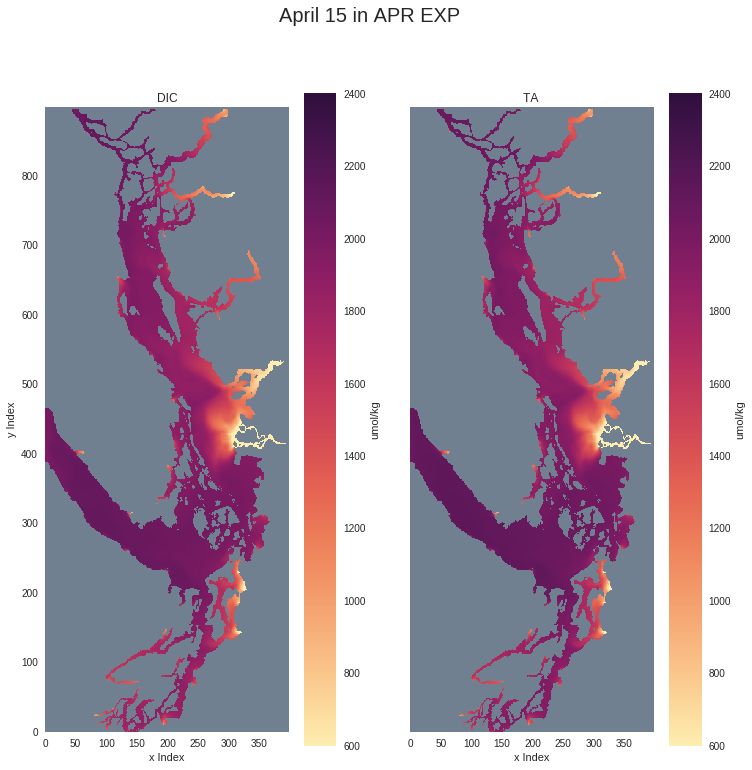

In [127]:
#task: make 2 panel plot of dic, ta, orig, and also ph, pco2, OmegaA
VP.two_panel_plot(tDIC*10e4,tTA*10e4,'DIC','TA ',cm.cm.matter,12,12,600,2400,600,2400,'umol/kg','umol/kg','April 15 in APR EXP')


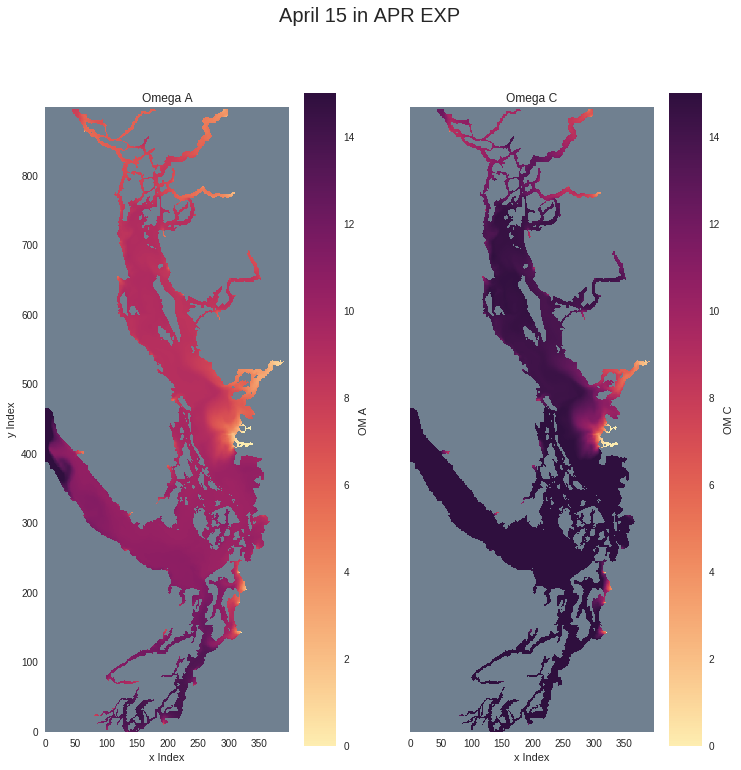

In [128]:
tOmegaA = np.ma.masked_values(tOmegaA,1e+20)
tOmegaC = np.ma.masked_values(tOmegaC,1e+20)
VP.two_panel_plot(tOmegaA,tOmegaC,'Omega A','Omega C',cm.cm.matter,12,12,0,15,0,15,'OM A ','OM C','April 15 in APR EXP')


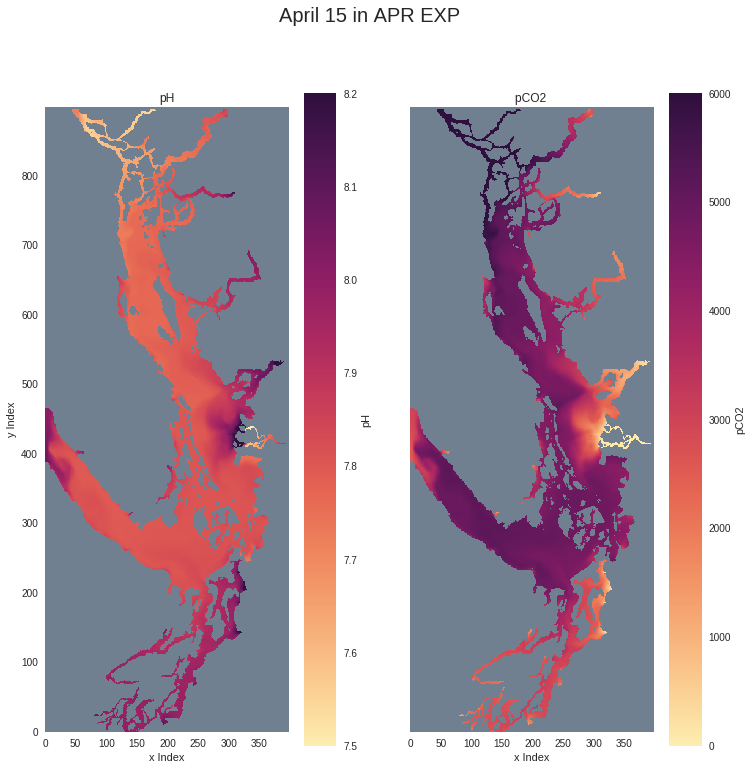

In [129]:
tpH = np.ma.masked_values(tpH,1e+20)
tpco2 = np.ma.masked_values(tpco2,1e+20)


VP.two_panel_plot(tpH,tpco2,'pH','pCO2 ',cm.cm.matter,12,12,7.5,8.2,0,6000,'pH','pCO2','April 15 in APR EXP')


In [143]:
y = 250
x = 250

print('point check for sanity')
print('note, all calc at surface, patm = 1, no silicate , no phosphate')
print('y coord is: ',y)
print('x coord is: ',x)


temp = 10
sal = 32
dic = 100 * 10e-6
alk = 100 * 10e-6


print('*')
print('*')
print('*')

# INPUT options:
# optCON: 'mol/kg'
# optT: 'Tpot'
# optP: 'm'
# optB: 'l10'
# optK1K2: 'm10'
# optKf: 'pf'
# optGAS: 'Ppot'

print('option 3 (my best guess for input opt): ')
print('optcon=mol/kg, optt=Tpot, optp=m, optb=110, optk1k2 = m10, optkf = pf, optgas = Ppot')
response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=0, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

print('pH is: ',pH)
print('pco2 is: ',pco2)
print('OmegaA is: ',OmegaA)
print('**')  
print('pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis')
print('**')
print(pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis)

point check for sanity
note, all calc at surface, patm = 1, no silicate , no phosphate
y coord is:  250
x coord is:  250
*
*
*
option 3 (my best guess for input opt): 
optcon=mol/kg, optt=Tpot, optp=m, optb=110, optk1k2 = m10, optkf = pf, optgas = Ppot
pH is:  [ 7.46372678]
pco2 is:  [ 528.4232118]
OmegaA is:  [ 0.24124654]
**
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis
**
[ 7.46372678] [ 528.4232118] [ 526.38768846] [  3.36956889e-05] [ 0.00095057] [  1.57355514e-05] [ 0.24124654] [ 0.3815774] [ 15.52141563] [ 1024.61028488] [ 0.] [ 10.00000018]


## create a property-space mesh visualisation



In [165]:
DICspace = np.arange(1800,2200,20) * 10e-6
TAspace = np.arange(1800,2200,20) * 10e-6
pHspace = np.zeros([20,20])
OmAspace = np.zeros([20,20])
pCO2space = np.zeros([20,20])

temp = 10
sal = 32
depth = 0

start = time.time()
for i in range(0,size(DICspace)):
    dic = DICspace[i]
    for j in range(0,size(DICspace)):
        alk = TAspace[j]
        
        response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=depth, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
        
        pHspace[i,j] = pH
        OmAspace[i,j] = OmegaA
        pCO2space[i,j] = pco2
        
end = time.time()       
print(end-start)


print(np.amax(OmAspace))

0.01805710792541504
56.1296179004


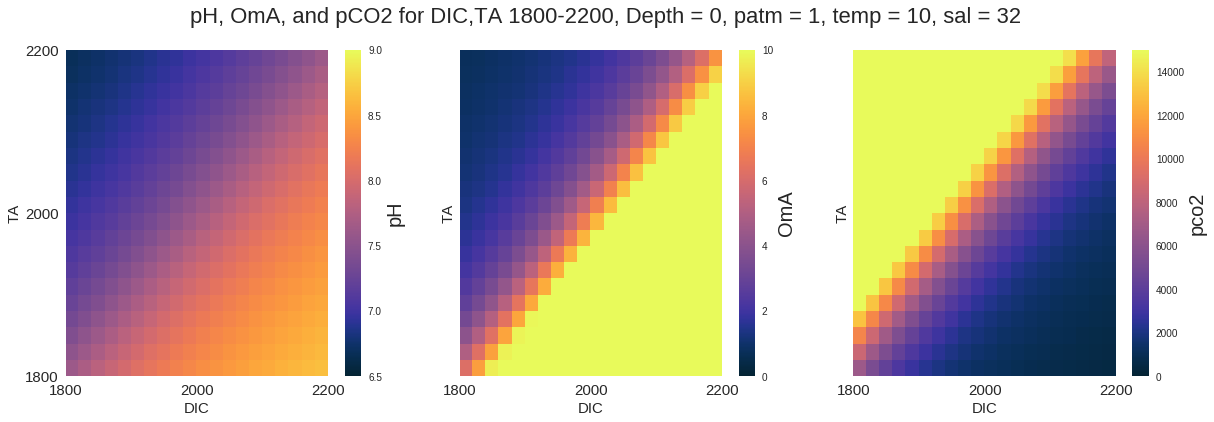

In [193]:
t_cmap = cm.cm.thermal
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
time_steps = (0,1,2)
for ax, t in zip(axs, time_steps):
    if t == 0:
        tplt = pHspace
        v_min = 6.5
        v_max = 9
        clabel = 'pH'
        
    if t == 1:
        tplt = OmAspace
        v_min = 0
        v_max = 10
        clabel = 'OmA'
    if t == 2:
        tplt = pCO2space
        v_min = 0
        v_max = 15000
        clabel = 'pco2'
        
        
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label(clabel, fontsize = 20)
    ax.set_xticks([0,10,20])
    ax.set_xticklabels(['1800','2000','2200'], fontsize = 15)
    ax.set_yticks([0,10,20])
    ax.set_yticklabels(['1800','2000','2200'], fontsize = 15)
    ax.set_xlabel('DIC', fontsize = 15)
    ax.set_ylabel('TA', fontsize = 15)
    titstr = 'pH, OmA, and pCO2 for DIC,TA 1800-2200, Depth = 0, patm = 1, temp = ' + str(temp) + ', sal = ' + str(sal)
plt.suptitle(titstr, fontsize = 22)

0.01231694221496582


/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


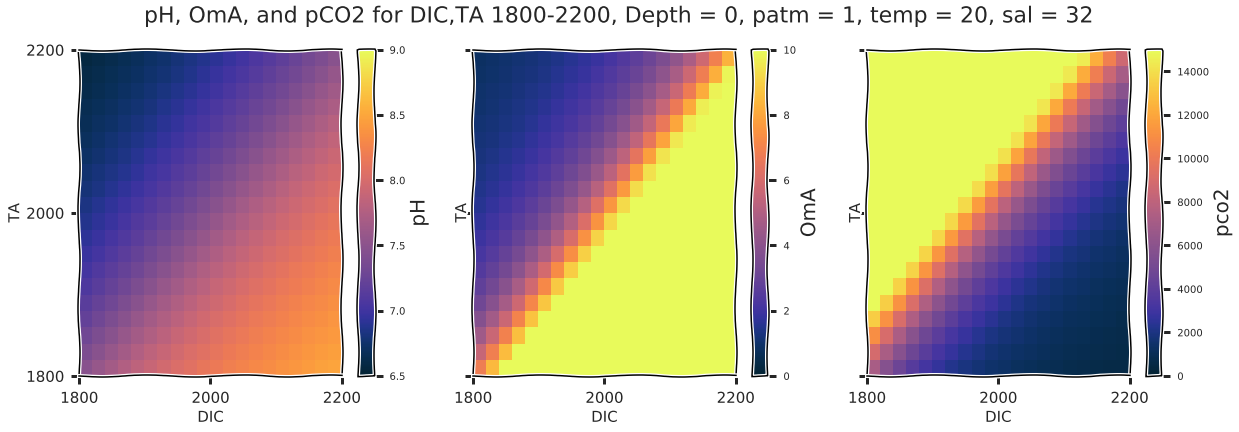

In [197]:
DICspace = np.arange(1800,2200,20) * 10e-6
TAspace = np.arange(1800,2200,20) * 10e-6
pHspace = np.zeros([20,20])
OmAspace = np.zeros([20,20])
pCO2space = np.zeros([20,20])

temp = 20
sal = 32
depth = 0

start = time.time()
for i in range(0,size(DICspace)):
    dic = DICspace[i]
    for j in range(0,size(DICspace)):
        alk = TAspace[j]
        
        response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=depth, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
        
        pHspace[i,j] = pH
        OmAspace[i,j] = OmegaA
        pCO2space[i,j] = pco2
        
end = time.time()       
print(end-start)

with plt.xkcd():
    t_cmap = cm.cm.thermal
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    time_steps = (0,1,2)
    for ax, t in zip(axs, time_steps):
        if t == 0:
            tplt = pHspace
            v_min = 6.5
            v_max = 9
            clabel = 'pH'

        if t == 1:
            tplt = OmAspace
            v_min = 0
            v_max = 10
            clabel = 'OmA'
        if t == 2:
            tplt = pCO2space
            v_min = 0
            v_max = 15000
            clabel = 'pco2'


        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max)
        cbar = fig.colorbar(mesh, ax=ax)
        cbar.set_label(clabel, fontsize = 20)
        ax.set_xticks([0,10,20])
        ax.set_xticklabels(['1800','2000','2200'], fontsize = 15)
        ax.set_yticks([0,10,20])
        ax.set_yticklabels(['1800','2000','2200'], fontsize = 15)
        ax.set_xlabel('DIC', fontsize = 15)
        ax.set_ylabel('TA', fontsize = 15)
        titstr = 'pH, OmA, and pCO2 for DIC,TA 1800-2200, Depth = 0, patm = 1, temp = ' + str(temp) + ', sal = ' + str(sal)
    plt.suptitle(titstr, fontsize = 22)

0.013182401657104492


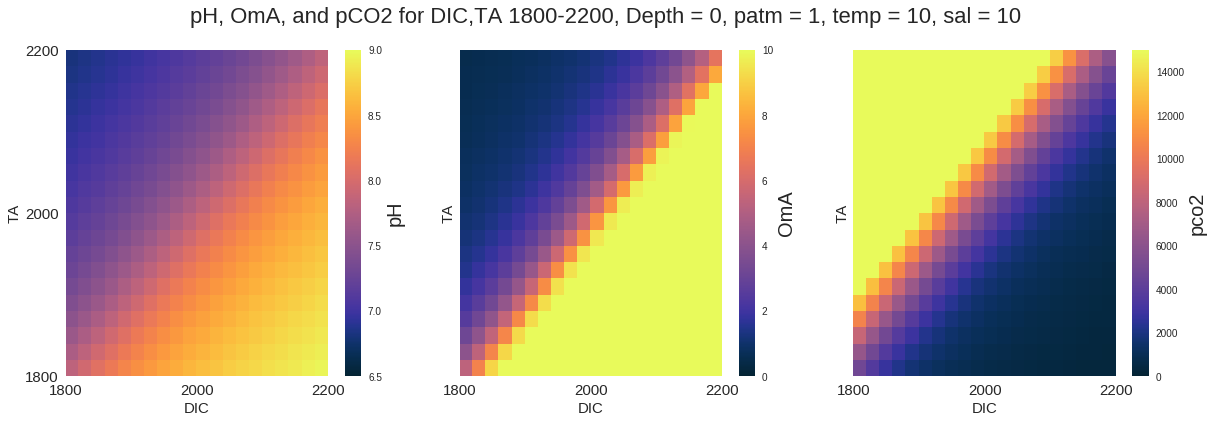

In [195]:
DICspace = np.arange(1800,2200,20) * 10e-6
TAspace = np.arange(1800,2200,20) * 10e-6
pHspace = np.zeros([20,20])
OmAspace = np.zeros([20,20])
pCO2space = np.zeros([20,20])

temp = 10
sal = 10
depth = 0

start = time.time()
for i in range(0,size(DICspace)):
    dic = DICspace[i]
    for j in range(0,size(DICspace)):
        alk = TAspace[j]
        
        response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=depth, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
        
        pHspace[i,j] = pH
        OmAspace[i,j] = OmegaA
        pCO2space[i,j] = pco2
        
end = time.time()       
print(end-start)


t_cmap = cm.cm.thermal
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
time_steps = (0,1,2)
for ax, t in zip(axs, time_steps):
    if t == 0:
        tplt = pHspace
        v_min = 6.5
        v_max = 9
        clabel = 'pH'
        
    if t == 1:
        tplt = OmAspace
        v_min = 0
        v_max = 10
        clabel = 'OmA'
    if t == 2:
        tplt = pCO2space
        v_min = 0
        v_max = 15000
        clabel = 'pco2'
        
        
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label(clabel, fontsize = 20)
    ax.set_xticks([0,10,20])
    ax.set_xticklabels(['1800','2000','2200'], fontsize = 15)
    ax.set_yticks([0,10,20])
    ax.set_yticklabels(['1800','2000','2200'], fontsize = 15)
    ax.set_xlabel('DIC', fontsize = 15)
    ax.set_ylabel('TA', fontsize = 15)
    titstr = 'pH, OmA, and pCO2 for DIC,TA 1800-2200, Depth = 0, patm = 1, temp = ' + str(temp) + ', sal = ' + str(sal)
plt.suptitle(titstr, fontsize = 22)

0.012670278549194336


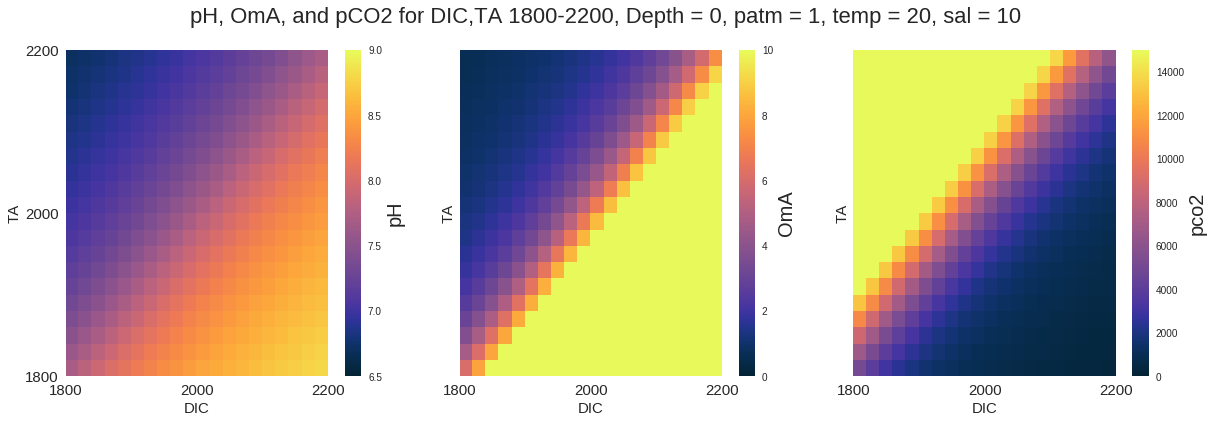

In [196]:
DICspace = np.arange(1800,2200,20) * 10e-6
TAspace = np.arange(1800,2200,20) * 10e-6
pHspace = np.zeros([20,20])
OmAspace = np.zeros([20,20])
pCO2space = np.zeros([20,20])

temp = 20
sal = 10
depth = 0

start = time.time()
for i in range(0,size(DICspace)):
    dic = DICspace[i]
    for j in range(0,size(DICspace)):
        alk = TAspace[j]
        
        response_tup = mocsy.mvars(temp=temp, sal=sal, alk=alk, dic=dic, sil=0, phos=0, 
                            patm=1, depth=depth, lat=50, optcon='mol/kg', optt='Tpot', optp='m',
                            optb='l10', optk1k2='m10',  optkf='pf', optgas='Ppot')
        pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
        
        pHspace[i,j] = pH
        OmAspace[i,j] = OmegaA
        pCO2space[i,j] = pco2
        
end = time.time()       
print(end-start)


t_cmap = cm.cm.thermal
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
time_steps = (0,1,2)
for ax, t in zip(axs, time_steps):
    if t == 0:
        tplt = pHspace
        v_min = 6.5
        v_max = 9
        clabel = 'pH'
        
    if t == 1:
        tplt = OmAspace
        v_min = 0
        v_max = 10
        clabel = 'OmA'
    if t == 2:
        tplt = pCO2space
        v_min = 0
        v_max = 15000
        clabel = 'pco2'
        
        
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label(clabel, fontsize = 20)
    ax.set_xticks([0,10,20])
    ax.set_xticklabels(['1800','2000','2200'], fontsize = 15)
    ax.set_yticks([0,10,20])
    ax.set_yticklabels(['1800','2000','2200'], fontsize = 15)
    ax.set_xlabel('DIC', fontsize = 15)
    ax.set_ylabel('TA', fontsize = 15)
    titstr = 'pH, OmA, and pCO2 for DIC,TA 1800-2200, Depth = 0, patm = 1, temp = ' + str(temp) + ', sal = ' + str(sal)
plt.suptitle(titstr, fontsize = 22)

## phase 2 - calculate wind flux parameters - gas transfer, schmidt number